## HW2 Problem Set

### problem 1

(a) Implement a naïve Bayes classifier for spam classification, using the multinomial
event model and Laplace smoothing (For Laplace smoothing, I will explain about this
in the next lecture).
You are going to use the code outline provided in hw2_nb.py to train your parameters,
and then use these parameters to classify the test set data by filling in the code.
Train your parameters using the document-word matrix in hw2_MATRIX.TRAIN, and
then report the test set error on hw2_MATRIX.TEST.

### 완성된 hw2_nb.py

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)

def nb_train(matrix, category):
    state = {}
    N = matrix.shape[1]

    ###################
    # Fill out your code here!
    # DO NOT use any naive Bayes related library.
    # You will implement this by yourself.
    # Avoid directly calculating the probability by dividing two numbers  
    # Instead use the logarithm for each numerator and denominator to avoid the underflow
    ###################
    
    classes = np.unique(category)
    n_classes = len(classes)
    
    class_counts = np.array([(category == c).sum() for c in classes])
    log_prior = np.log(class_counts / len(category))
    
    token_sum_per_class = np.zeros((n_classes, N))
    for i, c in enumerate(classes):
        token_sum_per_class[i, :] = matrix[category == c].sum(axis=0)
    
    # Laplace smoothing 적용
    alpha = 1
    log_likelihood = np.zeros((n_classes, N))
    for i in range(n_classes):
        numerator = token_sum_per_class[i] + alpha
        denominator = token_sum_per_class[i].sum() + alpha * N
        log_likelihood[i] = np.log(numerator / denominator)
    
    state['log_prior'] = log_prior
    state['log_likelihood'] = log_likelihood
    state['classes'] = classes
    
    return state

def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])

    ###################
    # Fill out your code here!
    # DO NOT use any naive Bayes related library.
    # You will implement this by yourself.
    ###################
    
    log_prior = state['log_prior']
    log_likelihood = state['log_likelihood']
    classes = state['classes']
    
    log_prob = matrix @ log_likelihood.T + log_prior
    output = np.argmax(log_prob, axis=1)
    output = classes[output]
    
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f'%error)

In [4]:
def main():
    # Please set a training file that you want to use for this run below
    trainMatrix, tokenlist, trainCategory = readMatrix('./sample/hw2_MATRIX.TRAIN')
    testMatrix, tokenlist, testCategory = readMatrix('./sample/hw2_MATRIX.TEST')

    state = nb_train(trainMatrix, trainCategory)
    output = nb_test(testMatrix, state)

    evaluate(output, testCategory)
    return

if __name__ == '__main__':
    main()

Error: 0.0163


test set error는 0.0163 입니다

(b) Intuitively, some tokens may be particularly indicative of an email being in a particular class. We can try to get an informal sense of how indicative token i is for
the SPAM class by looking at:
Using the parameters fit in part (a), find the 5 tokens that are most indicative of the SPAM class (i.e., have the highest positive value on the measure above). The numbered list of tokens in the file hw2_TOKENS_LIST should be useful for identifying
the words/tokens

In [6]:
trainMatrix, tokenlist, trainCategory = readMatrix('./sample/hw2_MATRIX.TRAIN')
testMatrix, tokenlist, testCategory = readMatrix('./sample/hw2_MATRIX.TEST')

state = nb_train(trainMatrix, trainCategory)

In [7]:
import numpy as np

log_ratios = state['log_likelihood'][1] - state['log_likelihood'][0]

# log-ratio가 클수록 SPAM에 더 강하게 연관된 단어
top5_idx = np.argsort(log_ratios)[-5:][::-1]

print("Top 5 SPAM-indicative tokens:")
for i in top5_idx:
    print(f"{tokenlist[i]}  (log-ratio={log_ratios[i]:.4f})")

Top 5 SPAM-indicative tokens:
httpaddr  (log-ratio=7.0258)
spam  (log-ratio=6.9709)
unsubscrib  (log-ratio=5.4225)
ebai  (log-ratio=5.1986)
valet  (log-ratio=5.1909)


학습된 naive bayse algorithm을 사용했을때 SPAM에 가장 강하과 연관된 5개 토큰은 httpadr, spam, unsubscrib, ebai, valet으로 확인된다.

(c) Repeat part (a), but with training sets of size ranging from 50, 100, 200, …, up to 1400, by using the files hw2_MATRIX.TRAIN.*. Plot the test error each time (use hw2_MATRIX.TEST as the test data) to obtain a learning curve (test set error vs. training set size). You may need to change the call in hw2_nb.py to read the correct file each time. Which training set size gives the best test set error?

In [8]:
import numpy as np
import matplotlib.pyplot as plt

train_sizes = [50, 100, 200, 400, 800, 1400]
test_errors = []

testMatrix, tokenlist, testCategory = readMatrix('./sample/hw2_MATRIX.TEST')

for size in train_sizes:
    train_file = f'./sample/hw2_MATRIX.TRAIN.{size}'
    trainMatrix, tokenlist, trainCategory = readMatrix(train_file)
    
    # 학습
    state = nb_train(trainMatrix, trainCategory)
    
    # 테스트
    output = nb_test(testMatrix, state)
    
    # 오류율 계산
    error = (output != testCategory).sum() / len(testCategory)
    test_errors.append(error)
    
    print(f"Training size: {size}, Test error: {error:.4f}")

Training size: 50, Test error: 0.0450
Training size: 100, Test error: 0.0312
Training size: 200, Test error: 0.0238
Training size: 400, Test error: 0.0163
Training size: 800, Test error: 0.0163
Training size: 1400, Test error: 0.0163


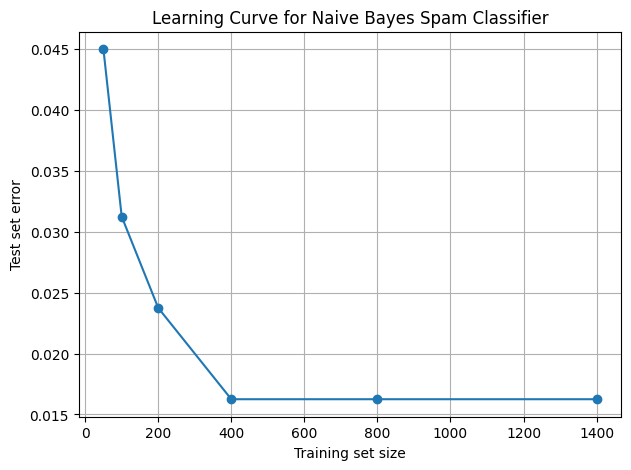

In [9]:
plt.figure(figsize=(7,5))
plt.plot(train_sizes, test_errors, marker='o', linestyle='-')
plt.xlabel('Training set size')
plt.ylabel('Test set error')
plt.title('Learning Curve for Naive Bayes Spam Classifier')
plt.grid(True)
plt.show()

학습 데이터 사이즈가 50에서 400으로 커질수록 test error rate는 점차 감소하는 모습을 확인할 수 있다. 가장 낮은 test error rate는 training set size가 400일때인 것으로 보인다.

### problem 2

2. Spam Classification via SVM. In this problem, we will train an SVM on the same dataset used in Prob #1, using the linear kernel and Gaussian RBF kernel . <br />(a) We will compare three SVM implementations with hard margin (with C = 0), soft margin with C (for slack variables),and kernelized SVM with Gaussian RBF kernel as in hw2_svm.py. Report the test set error on hw2_MATRIX.TEST for each implementation and compare them.

In [12]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def svm_readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category


def svm_test(svm, matrix):
    ###################
    # Fill out your code here!
    ###################
    output = svm.predict(matrix)
    return output


def svm_evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f'%error)
    return error

In [15]:
def main():
    # Load training & test data
    trainMatrix, tokenlist, trainCategory = svm_readMatrix('./sample/hw2_MATRIX.TRAIN.400')
    testMatrix, tokenlist, testCategory = svm_readMatrix('./sample/hw2_MATRIX.TEST')

    # Define SVM models
    svm_clf_hard = SVC(kernel="linear", C=float("inf"), max_iter=10_000, random_state=42)
    svm_clf_soft = SVC(kernel="linear", C=1, max_iter=10_000, random_state=42)
    svm_clf_rbf = SVC(kernel="rbf", gamma=8, C=0.001, max_iter=10_000, random_state=42)

    scaler = StandardScaler()

    # Use scaled pipeline for each model
    scaled_svm_clf_hard = make_pipeline(scaler, svm_clf_hard)
    scaled_svm_clf_soft = make_pipeline(scaler, svm_clf_soft)
    scaled_svm_clf_rbf = make_pipeline(scaler, svm_clf_rbf)

    # Train
    scaled_svm_clf_hard.fit(trainMatrix, trainCategory)
    scaled_svm_clf_soft.fit(trainMatrix, trainCategory)
    scaled_svm_clf_rbf.fit(trainMatrix, trainCategory)

    # Test
    output_hard = svm_test(scaled_svm_clf_hard, testMatrix)
    output_soft = svm_test(scaled_svm_clf_soft, testMatrix)
    output_rbf = svm_test(scaled_svm_clf_rbf, testMatrix)

    # Evaluate test set errors
    print("Hard Margin SVM")
    err_hard = svm_evaluate(output_hard, testCategory)
    print("Soft Margin SVM")
    err_soft = svm_evaluate(output_soft, testCategory)
    print("Gaussian RBF SVM")
    err_rbf = svm_evaluate(output_rbf, testCategory)

if __name__ == '__main__':
    main()

Hard Margin SVM
Error: 0.0350
Soft Margin SVM
Error: 0.0350
Gaussian RBF SVM
Error: 0.5000


hard margin과 soft margin SVM 모두 3.5%의 test error rate를 보여 가장 우수한 성능을 보였다. RBF kernel SVM은 50%의 높은 error rate를 보여 주어진 파라미터 설정에서는 성능이 크게 저하되는 것을 확인할 수 있었다.

(b) Repeat Prob #1(c) for three SVMs and plot the test error of them together with the
naïve Bayes (from Prob #1(c)), (i.e., four lines for four algorithms altogether in a
single plot).

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

testMatrix, tokenlist, testCategory = readMatrix('./sample/hw2_MATRIX.TEST')
train_sizes = [50, 100, 200, 400, 800, 1400]

nb_errors = []
svm_hard_errors = []
svm_soft_errors = []
svm_rbf_errors = []

scaler = StandardScaler()
for size in train_sizes:
    print(f"Training size: {size}")
    train_file = f'./sample/hw2_MATRIX.TRAIN.{size}'
    trainMatrix, tokenlist, trainCategory = readMatrix(train_file)
    category = (trainCategory * 2) - 1  # for SVM

    # Naive Bayes 
    nb_state = nb_train(trainMatrix, trainCategory)
    nb_pred = nb_test(testMatrix, nb_state)
    nb_error = (nb_pred != testCategory).sum() / len(testCategory)
    nb_errors.append(nb_error)

    # Hard Margin SVM
    svm_hard = make_pipeline(
        scaler,
        SVC(kernel="linear", C=float("inf"), max_iter=10_000, random_state=42)
    )
    svm_hard.fit(trainMatrix, category)
    pred_hard = svm_hard.predict(testMatrix)
    err_hard = (pred_hard != ((testCategory * 2) - 1)).sum() / len(testCategory)
    svm_hard_errors.append(err_hard)

    # Soft Margin SVM
    svm_soft = make_pipeline(
        scaler,
        SVC(kernel="linear", C=1, max_iter=10_000, random_state=42)
    )
    svm_soft.fit(trainMatrix, category)
    pred_soft = svm_soft.predict(testMatrix)
    err_soft = (pred_soft != ((testCategory * 2) - 1)).sum() / len(testCategory)
    svm_soft_errors.append(err_soft)

    # RBF Kernel SVM
    svm_rbf = make_pipeline(
        scaler,
        SVC(kernel="rbf", gamma=8, C=0.001, max_iter=10_000, random_state=42)
    )
    svm_rbf.fit(trainMatrix, category)
    pred_rbf = svm_rbf.predict(testMatrix)
    err_rbf = (pred_rbf != ((testCategory * 2) - 1)).sum() / len(testCategory)
    svm_rbf_errors.append(err_rbf)

Training size: 50
Training size: 100
Training size: 200
Training size: 400
Training size: 800
Training size: 1400


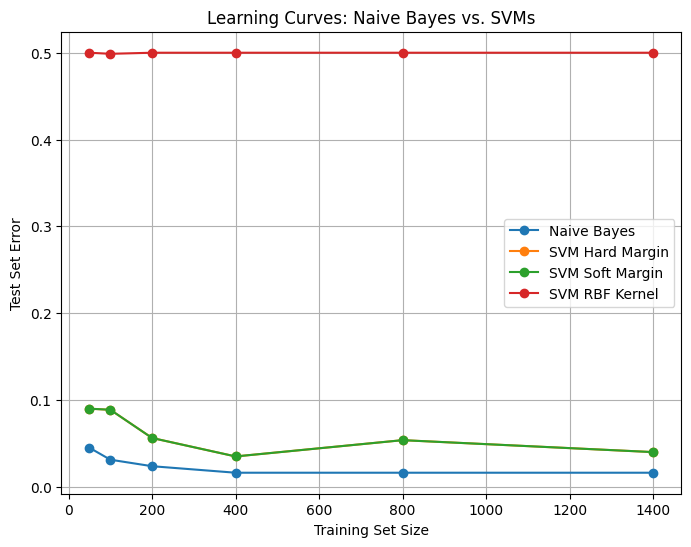

In [17]:
plt.figure(figsize=(8,6))
plt.plot(train_sizes, nb_errors, 'o-', label='Naive Bayes')
plt.plot(train_sizes, svm_hard_errors, 'o-', label='SVM Hard Margin')
plt.plot(train_sizes, svm_soft_errors, 'o-', label='SVM Soft Margin')
plt.plot(train_sizes, svm_rbf_errors, 'o-', label='SVM RBF Kernel')
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error')
plt.title('Learning Curves: Naive Bayes vs. SVMs')
plt.legend()
plt.grid(True)
plt.show()

4가지 classifier의 learning curve를 비교한 결과 naive bayse와 svm은 training data set이 증가할 수록 test error rate가 감소하며 0.02~0.05 정도 수준에서 수렴하는 것을 확인할 수 있다. <br/> svm hard margin과 soft margin 곡선이 거의 일치(overlap)하는데 찾아본 결과 그 이유는 데이터가 애초에 선형적으로 잘 구분 가능하기 때문에 C값의 변화가 decision boundary에 큰 영향을 주지 않기 때문이라고 한다. <br/> 다만 SVM RBF Kernel은 underfit가 발생했으며 모든 training set에서 0.5의 높은 error rate를 보였다. <br />결론적으로 데이터에서는 나이브 베이즈와 linear svm이 가장 적합한 모델로 판단된다.